In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.columns = ['Sales']

In [5]:
df.shape

(325, 1)

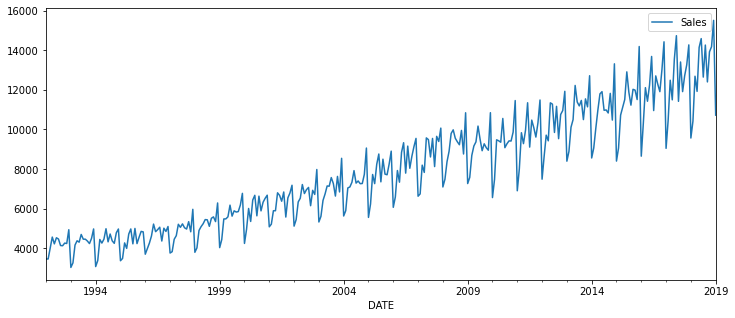

In [6]:
df.plot(figsize=(12,5));

# Seasonal Decomposition

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

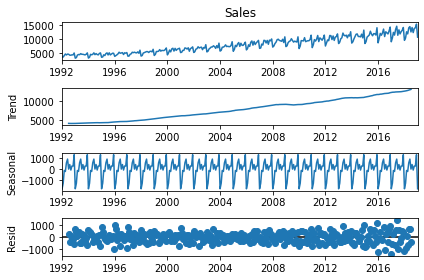

In [8]:
results = seasonal_decompose(df['Sales'])
results.plot();

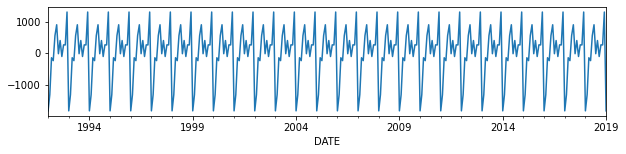

In [9]:
results.seasonal.plot(figsize=(10,2));

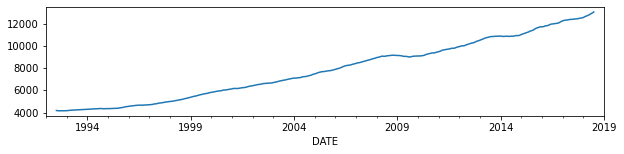

In [10]:
results.trend.plot(figsize=(10,2));

# Train Test Split

In [11]:
length = len(df.Sales)
stop = length-12

In [12]:
train = df[:stop]
test = df[stop:]

In [13]:
print(test.shape)
print(train.shape)

(12, 1)
(313, 1)


# Scaling the data  

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scaler.fit(train)

MinMaxScaler()

In [17]:
scaled_train = scaler.transform(train)

In [18]:
scaled_test = scaler.transform(test)

# Creating the model

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
n_estimators = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_estimators,batch_size=n_features)

In [21]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_estimators, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit_generator(generator,epochs=50)

Epoch 1/50
301/301 [==============================] - 24s 3ms/step - loss: 0.0473
Epoch 2/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0101
Epoch 3/50
301/301 [==============================] - 1s 4ms/step - loss: 0.0096
Epoch 4/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0100
Epoch 5/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0099
Epoch 6/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0085
Epoch 7/50
301/301 [==============================] - 1s 4ms/step - loss: 0.0067
Epoch 8/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0042
Epoch 9/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0044
Epoch 10/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 11/50
301/301 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 12/50
301/301 [==============================] - 1s 4ms/step - loss: 0.0024
Epoch 13/50
301/301 [===

# Predictions on test data

In [24]:
first_eval_batch = scaled_train[-12:]

In [25]:
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [26]:
first_eval_batch = first_eval_batch.reshape(1,n_estimators,n_features)

In [27]:
model.predict(first_eval_batch)

array([[0.74342096]], dtype=float32)

In [28]:
predictions=[]
first_eval_batch = scaled_train[-n_estimators:]
current_eval_batch = first_eval_batch.reshape(1,n_estimators,n_features)
for i in range(len(test)):
    curr_pred = model.predict(current_eval_batch)[0]
    predictions.append(curr_pred)
    current_eval_batch = np.append(current_eval_batch[:,1:,:],curr_pred,axis=1)

In [29]:
predictions

[array([0.74342096], dtype=float32),
 array([0.8821233], dtype=float32),
 array([0.8116778], dtype=float32),
 array([0.9933598], dtype=float32),
 array([1.0830333], dtype=float32),
 array([0.7952782], dtype=float32),
 array([0.99010336], dtype=float32),
 array([0.8243485], dtype=float32),
 array([0.92494226], dtype=float32),
 array([0.95020884], dtype=float32),
 array([1.0554771], dtype=float32),
 array([0.6363567], dtype=float32)]

# Inverse Transformation and comparisition

In [30]:
true_predictions = scaler.inverse_transform(predictions)

In [31]:
true_predictions

array([[11728.28179371],
       [13350.96038717],
       [12526.81874049],
       [14652.31634879],
       [15701.40684915],
       [12334.95956314],
       [14614.21925533],
       [12675.05321044],
       [13851.89944148],
       [14147.49325138],
       [15379.02708817],
       [10475.73716652]])

In [32]:
test['Forecast'] = true_predictions

<AxesSubplot:xlabel='DATE'>

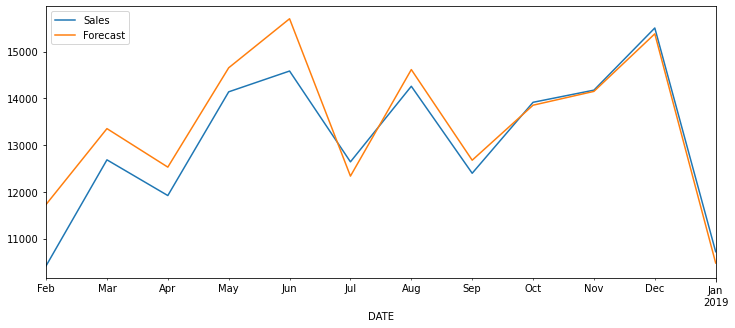

In [33]:
test.plot(figsize=(12,5))